# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb
import matplotlib.pyplot as plt
from utils import *
plt.style.use('seaborn-whitegrid')
%matplotlib inline

asl = AslDb() # initializes the database
#asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

##### Try it!

In [2]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
grnd=dict()
grnd['lx']=('left','x')
grnd['ly']=('left','y')
grnd['rx']=('right','x')
grnd['ry']=('right','y')
#collect the features in a list
features_ground=features_list('grnd')
for k,v in grnd.items():
    asl.df['grnd-'+k]=asl.df[v[0]+'-'+v[1]] - asl.df['nose-'+v[1]]
    # test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-lx  grnd-ry  grnd-rx  grnd-ly  
video frame                                      
98    0          -12      113        9      119  
      1          -12      113        9      119  
      2          -12      113        9      119  
      3          -12      113        9      119  
      4          -12      113        9      119

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [5]:
training_ground = asl.build_training(features_ground)
print("Training words: {}".format(training_ground.words))

Training words: ['BILL', 'SHOOT', 'VIDEOTAPE', 'GIVE', 'HOMEWORK', 'SAY', 'WHO', 'MARY', 'LIKE', 'MANY', 'STUDENT', 'WRITE', 'MOTHER', 'BROCCOLI', 'GIVE1', 'CHICKEN', 'MAN', 'WANT', 'ALL', 'BUT', 'CAR', 'GIVE3', 'HOUSE', 'WOMAN', 'JANA', 'SELL', 'BOY', 'TEACHER', 'SHOULD', 'BOX', 'FRIEND', 'PEOPLE', 'HAVE', 'FRED', 'NEW', 'IX', 'FISH', 'NEXT-WEEK', 'GIRL', 'THROW', 'LEG', 'LOVE', 'FINISH', 'GO1', 'LAST-WEEK', 'POSS', 'SAY-1P', 'YESTERDAY', 'BUY', 'ANN', 'CHOCOLATE', 'SUE', 'APPLE', 'PUTASIDE', 'FUTURE', 'CAN', 'NEW-YORK', 'COAT', 'JOHN', 'VEGETABLE', 'BUY1', 'SOMETHING-ONE', 'GO', 'TELL', 'PAST', 'SEARCH-FOR', 'TOY1', 'TOMORROW', 'THINK', 'SEE', 'BORROW', 'CANDY', 'CORN', 'LIVE', 'WHAT', 'CHICAGO', 'ARRIVE', 'SELF', 'NAME', 'GO2', 'BOOK', 'NOT', 'GET', 'EAT', 'MOVIE', 'READ', 'WONT', 'BLAME', 'FRANK', 'LEAVE', 'TOY', 'HIT', 'PARTY', 'BLUE', 'GROUP', 'STOLEN', 'PREFER', 'DECIDE', 'WILL', 'KNOW', 'GIVE2', 'FIND', 'IX-1P', 'FUTURE1', 'CHINA', 'VISIT', 'HERE', 'OLD', 'POTATO', 'BREAK-DOWN'

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [6]:
training_ground_sample=dict()
words=['CHOCOLATE','VEGETABLE','STUDENT']
for word in words:
       training_ground_sample[word]=get_sample(training_ground,word)

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [7]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-lx,grnd-ly,grnd-rx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,31.216447,157.036848,-19.567406
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,2.006318,104.026144,-11.637255
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,12.895536,118.505134,-13.452679


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

##### Try it!

In [8]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-lx,grnd-ly,grnd-rx
speaker,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,15.080360,36.572749,20.269032
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,17.328941,27.117393,16.764706
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,15.050938,29.320655,16.191324


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [3]:
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

features_norm = features_list('norm')
direction={'r':'right','l':'left'}
for f in features_norm:
    key='grnd-'+f[5:8]
    key=direction[f[5]]+'-'+f[6]
    asl.df[f]=(asl.df[key]-asl.df['speaker'].map(df_means[key]))/asl.df['speaker'].map(df_std[key])

col='grnd'
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
asl.df['polar-rtheta']=(np.arctan2(asl.df[col+'-rx'],asl.df[col+'-ry']))
asl.df['polar-ltheta']=(np.arctan2(asl.df[col+'-lx'],asl.df[col+'-ly']))
asl.df['polar-rr']=np.sqrt(asl.df[col+'-rx']**2+asl.df[col+'-ry']**2)
asl.df['polar-lr']=np.sqrt(asl.df[col+'-lx']**2+asl.df[col+'-ly']**2)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
for f in features_delta:
    key='norm-'+f[6:9]  
    key=direction[f[6]]+'-'+f[7]
    asl.df[f]=(asl.df[key].diff()).fillna(0)

In [5]:
features=dict()
for f in [features_ground,features_norm,features_polar,features_delta]:
    features[f[0].split('-')[0]]=f

training=dict()
for k,v in features.items():
    training[k]=asl.build_training(v)

** Assumption 1:** *Words with more samples/occurences will yield more robust results in the modelin terms of signal vs noise.*

**Assumption 2:** *Focusing on high-frequency words will have the highest impact on prediction results. *

**Assumption 3:** *At least five data points are required in a sample (from Thad in lectures). *

==> let's use the top 3 most frequent words, constrained on having 5> data points, for testing.

In [53]:
xlens=training['grnd'].get_all_Xlengths()
words=[k for k,v in xlens.items() if len(v[1])>15 and min(v[1])>5]

In [54]:
samples=dict()
features_set='grnd'
samples[features_set]=dict()
for word in words:
    samples[features_set][word]=get_word(training,features,features_set,word)

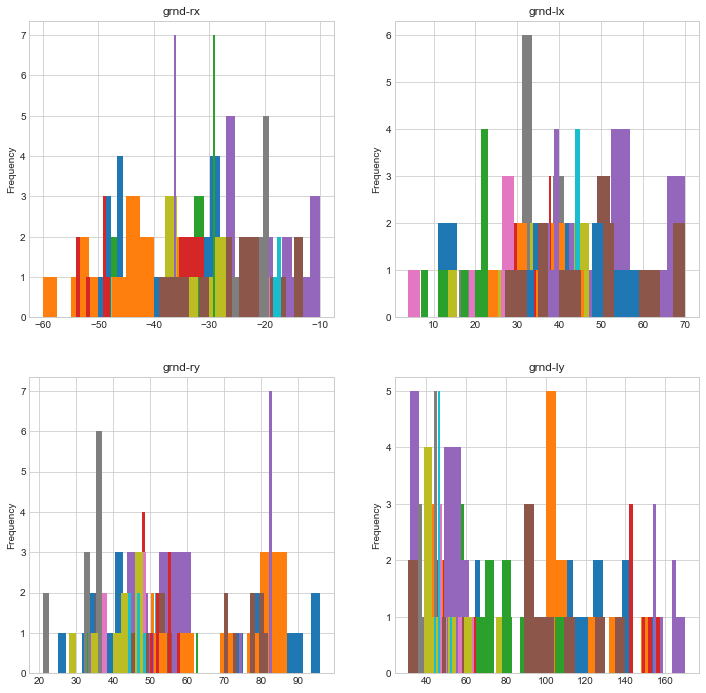

In [55]:
fig=make_histogram(samples['grnd'][words[0]])

What a mess... The data is all over the place without distinct clusters. Let's check another one.

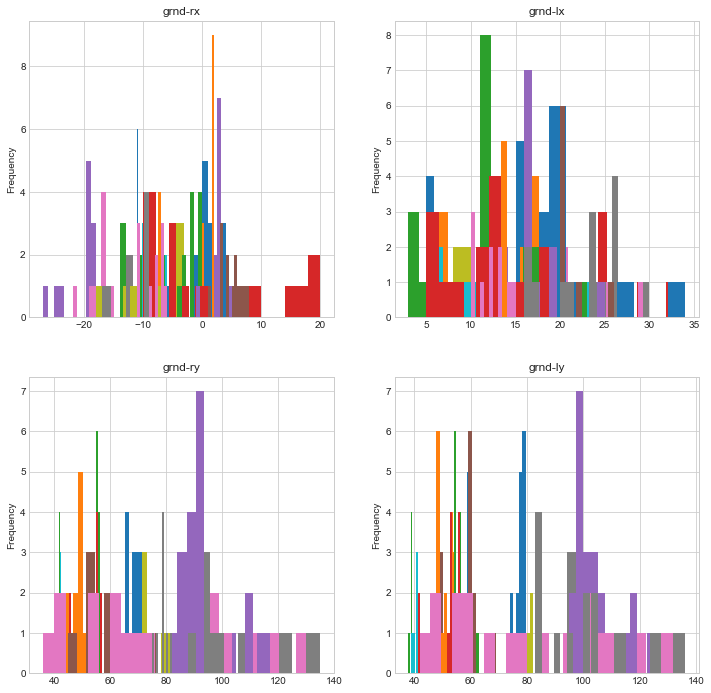

In [56]:
fig=make_histogram(samples[features_set][words[1]])

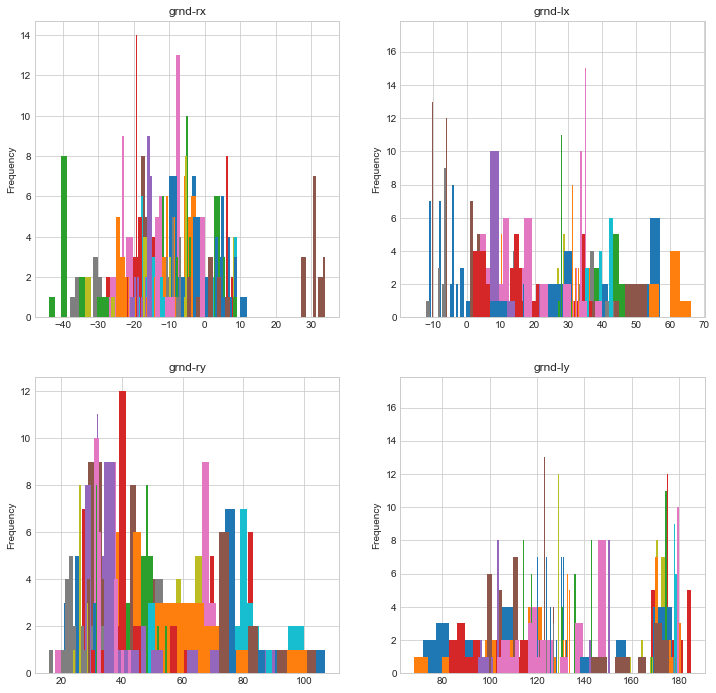

In [57]:
fig=make_histogram(samples[features_set][words[2]])

OK, we can seem some clustering for samples with higher number of data points. OTOH some of the features seem spread out/noisy for the left hand. Perhaps the normalized data will look better.

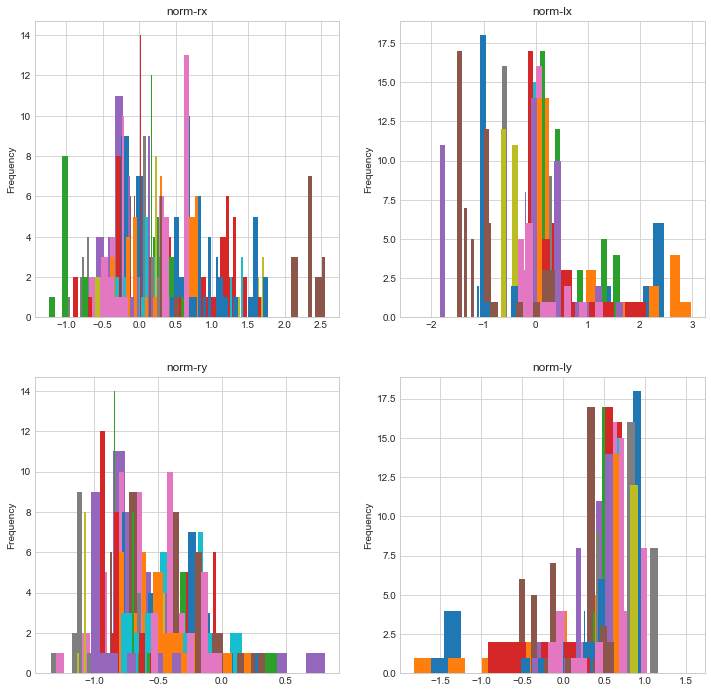

In [58]:
samples=dict()
features_set='norm'
samples[features_set]=dict()
for word in words:
    samples[features_set][word]=get_word(training,features,features_set,word)
    
fig=make_histogram(samples['norm'][words[2]])

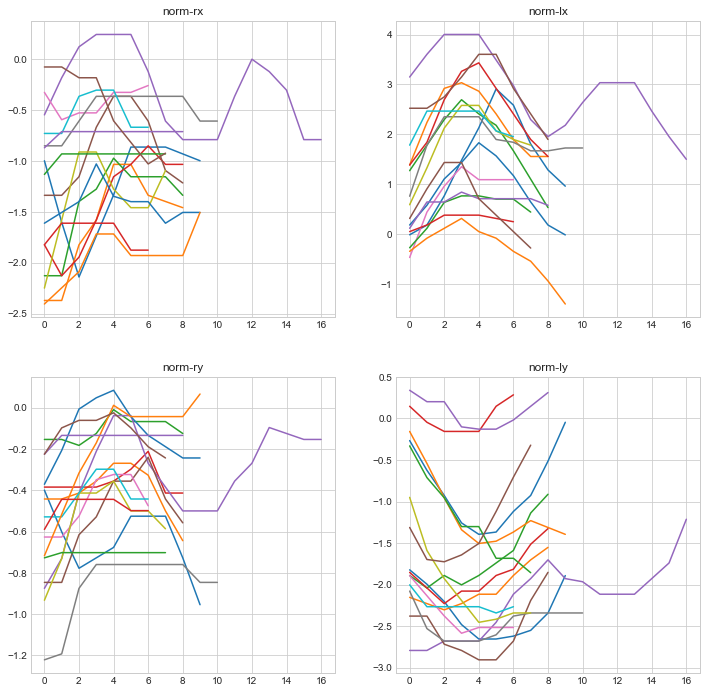

In [71]:
#reload(utils)
fig=utils.make_lines(samples['norm'][words[0]])

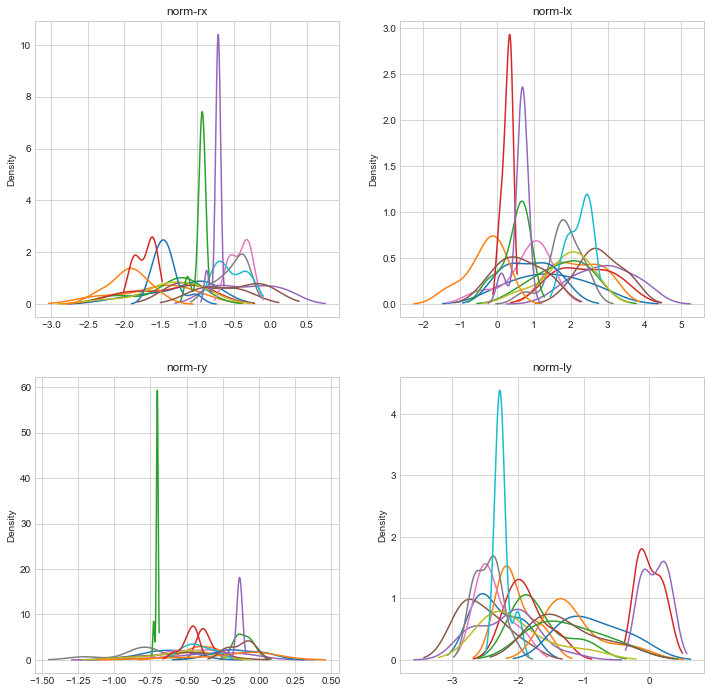

In [70]:
fig=utils.make_kde(samples['norm'][words[0]])

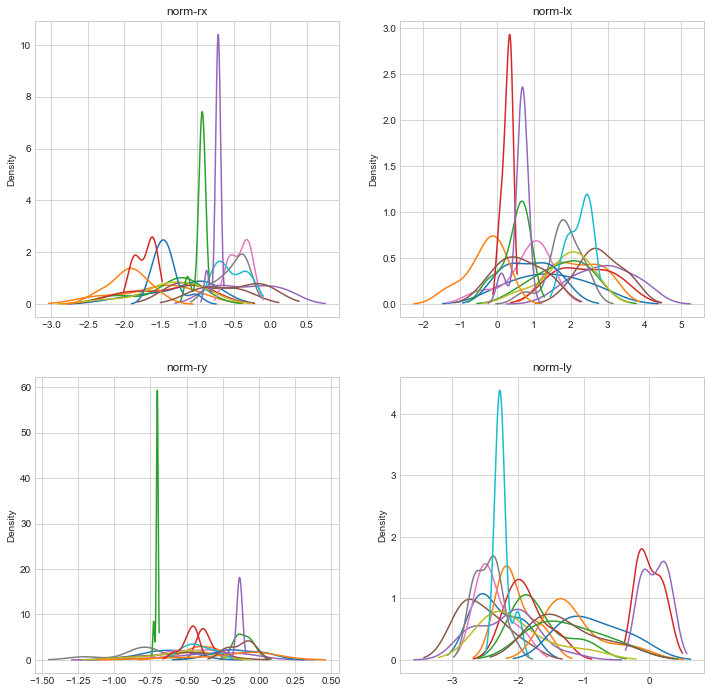

In [70]:
fig=utils.make_kde(samples['norm'][words[0]])

In [25]:
# TODO add features of your own design, which may be a combination of the above or something else
# Polar coordinates from normalized
col='norm'
features_custom= ['custom-rr', 'custom-rtheta', 'custom-lr', 'custom-ltheta']
asl.df['custom-rtheta']=(np.arctan2(asl.df[col+'-rx'],asl.df[col+'-ry']))
asl.df['custom-ltheta']=(np.arctan2(asl.df[col+'-lx'],asl.df[col+'-ly']))
asl.df['custom-rr']=np.sqrt(asl.df[col+'-rx']**2+asl.df[col+'-ry']**2)
asl.df['custom-lr']=np.sqrt(asl.df[col+'-lx']**2+asl.df[col+'-ly']**2)

# LR distance on xy-axis 
col='grnd'
asl.df['custom-xsep']=asl.df[col+'-rx']-asl.df[col+'-lx']
asl.df['custom-ysep']=asl.df[col+'-ry']-asl.df[col+'-ly']

features_custom_delta = [f+'-d' for f in features_custom]
for f in features_custom:
    asl.df[f+'-d']=(asl.df[f].diff()).fillna(0)
    
features_custom_sum = [f+'-s' for f in features_custom]
for f in features_custom:
    asl.df[f+'-s']=(asl.df[f].cumsum())

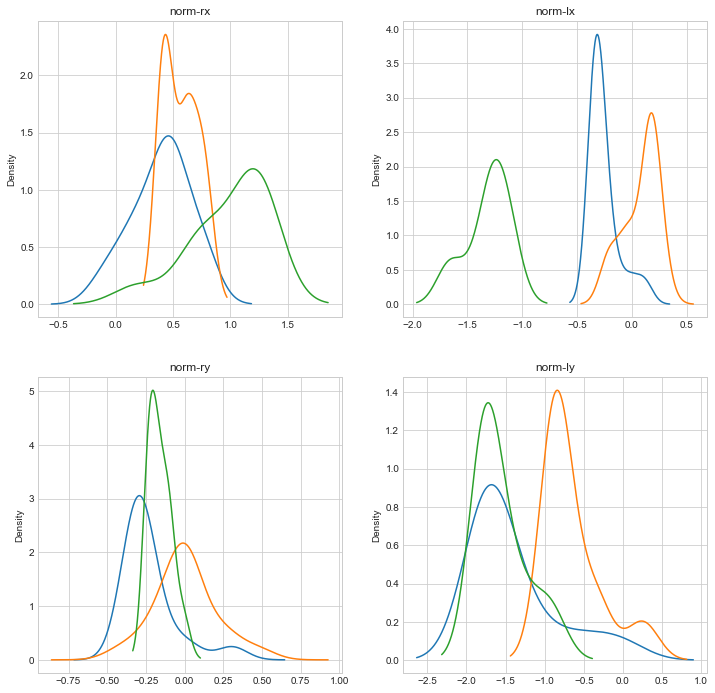

In [235]:
fig_kde=make_kde(,figsize=(12,12))

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** I chose polar coordinates from normalized values. At this point I want to keep the number of features constant at four. Polar coordinates makes sense, and should be using the normalized values to reduce idiosyncratic differences between speakers. I also made difference and integral/sum of my custom polar features.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [26]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.324s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [33]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL


In [44]:
models=dict()
features_names=['grnd','polar','delta','norm','custom']
df=pd.DataFrame(index=features_names)
from importlib import reload
import utils
reload(utils)
comparison=dict()

model grnd on IX: 3 states, logL -8.6e+03
model polar on IX: 3 states, logL -3.8e+03
model delta on IX: 3 states, logL +2e+02
model norm on IX: 3 states, logL -1.2e+03
model custom on IX: 3 states, logL -1.6e+03


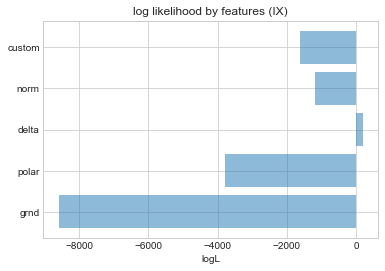

In [45]:
word=words[0]
model,logL=utils.likelihood_comparison(train_a_word,features,word)
fig=utils.likelihood_barchart(logL,word)
models[word]=model
comparison[word]=df.join(pd.DataFrame.from_dict(logL,orient='index')).rename(columns={0:word})

model grnd on JOHN: 3 states, logL -1.8e+04
model polar on JOHN: 3 states, logL -7.6e+03


C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


model delta on JOHN: 3 states, logL +5.9e+02
model norm on JOHN: 3 states, logL -1.8e+03
model custom on JOHN: 3 states, logL -3.1e+03


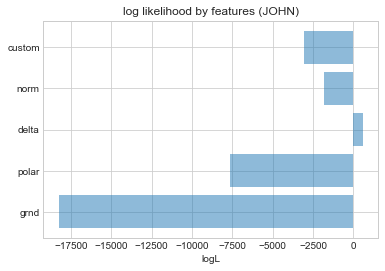

In [46]:
word=words[1]
model,logL=utils.likelihood_comparison(train_a_word,features,word)
fig=utils.likelihood_barchart(logL,word)
models[word]=model
comparison[word]=df.join(pd.DataFrame.from_dict(logL,orient='index')).rename(columns={0:word})

The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [264]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ 0.91690991  1.85971352  2.13544221 -2.83401696]
variance =  [0.12916669 0.07888934 0.17912948 0.02222892]

hidden state #1
mean =  [0.6792196  2.04179536 2.14685941 2.88540493]
variance =  [0.20695099 0.09338824 0.09482151 0.01507762]

hidden state #2
mean =  [ 0.66842187  0.84007872  1.25816956 -1.99946423]
variance =  [0.0216259  0.18443385 0.07413197 4.2710488 ]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [238]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [  0.58333333  87.91666667  12.75       108.5       ]
variance =  [ 39.41055556  18.74388889   9.855      144.4175    ]

hidden state #1
mean =  [-9.30211403 55.32333876  6.92259936 71.24057775]
variance =  [16.16920957 46.50917372  3.81388185 15.79446427]

hidden state #2
mean =  [-5.40587658 60.1652424   2.32479599 91.3095432 ]
variance =  [  7.95073876  64.13103127  13.68077479 129.5912395 ]

logL = -601.3291470028631


In [260]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 0.78560152  1.92579509  1.88221066 -2.68915598]
variance =  [0.1161804  0.07808317 0.07879657 0.07542306]

hidden state #1
mean =  [0.43330253 1.18439959 0.97778643 2.37549857]
variance =  [0.02853555 0.35903029 0.04357431 3.01080788]

hidden state #2
mean =  [ 0.64875929  1.82353359  0.57082867 -1.00114063]
variance =  [0.02241773 0.18054854 0.05569911 5.86986803]

logL = -91.30780676442124


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [ ]:
%matplotlib inline

In [258]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        


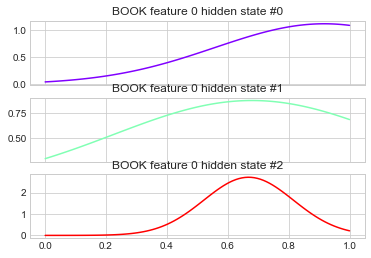

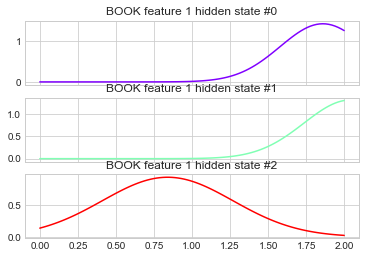

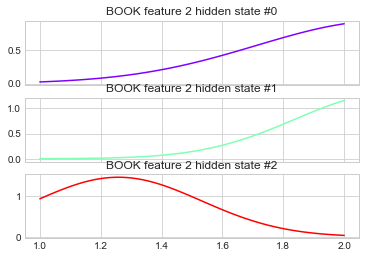

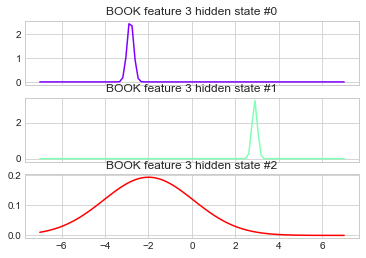

In [265]:
for word in ['BOOK']:
    visualize(word, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [30]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
word = words[0] # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3,verbose=True).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

model created for CHOCOLATE with 3 states
Number of states trained in model for CHOCOLATE is 3


         1        -208.5844             +nan
         2        -124.8003         +83.7840
         3         -99.8199         +24.9804
         4         -94.4872          +5.3327
         5         -91.7719          +2.7153
         6         -91.4032          +0.3687
         7         -91.3399          +0.0633
         8         -91.3191          +0.0208
         9         -91.3112          +0.0080


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [228]:
from sklearn.model_selection import KFold

training = asl.build_training(features_custom) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [32]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [16]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [49]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV
verbose=False

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word,verbose=verbose, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.2490176999999676 seconds
Training complete for BOOK with 3 states with time 0.36008419999961916 seconds
Training complete for VEGETABLE with 3 states with time 0.04188090000025113 seconds
Training complete for FUTURE with 3 states with time 0.06002379999972618 seconds
Training complete for JOHN with 3 states with time 3.0972614000002068 seconds


In [38]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC
verbose=False
training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word,verbose=verbose, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

         1          88.4049             +nan
         2         137.9234         +49.5185
         3         147.1543          +9.2309
         4         148.7481          +1.5938
         5         149.2335          +0.4854
         6         149.2382          +0.0047
         1          89.8390             +nan
         2         177.6474         +87.8083
         3         187.0219          +9.3746
         4         187.0642          +0.0423
         5         187.0818          +0.0176
         6         187.1029          +0.0211
         7         187.1283          +0.0254
         8         187.1602          +0.0319
         9         187.2026          +0.0423
        10         187.2627          +0.0601
        11         187.3551          +0.0924
        12         187.5101          +0.1550
        13         187.7920          +0.2820
        14         188.3130          +0.5209
        15         189.0856          +0.7726
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-pac

model created for FISH with 2 states
model created for FISH with 3 states
model created for FISH with 4 states
model created for FISH with 5 states


         1          87.2559             +nan
         2         172.5056         +85.2497
         3         190.6916         +18.1860
         4         197.0196          +6.3280
         5         202.2912          +5.2717
         6         203.4603          +1.1691
         7         204.0354          +0.5751
         8         204.1920          +0.1566
         9         204.1980          +0.0060


model created for FISH with 6 states


         1          86.0129             +nan
         2         170.0655         +84.0526
         3         190.5984         +20.5329
         4         198.2853          +7.6868
         5         202.3769          +4.0916
         6         203.1528          +0.7760
         7         203.5072          +0.3544
         8         203.7256          +0.2184
         9         203.8110          +0.0854
        10         203.8330          +0.0219
        11         203.8376          +0.0046
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         1          86.2687             +nan
         2         166.0535         +79.7848
         3         185.4854         +19.4319
         4         196.4313         +10.9459
         5         202.8890          +6.4576
         6         204.0464          +1.1575
         7         204.1837          +0.1373
         8         204.1969   

model created for FISH with 7 states
model created for FISH with 8 states
model created for FISH with 9 states


         2         158.4759         +69.0987
         3         172.7168         +14.2409
         4         179.6178          +6.9010
         5         184.6143          +4.9965
         6         185.9330          +1.3187
         7         186.0695          +0.1366
         8         186.0825          +0.0130
         9         186.0837          +0.0012
         1          90.8038             +nan
         2         153.1080         +62.3043
         3         166.1848         +13.0768
         4         173.4429          +7.2581
         5         177.9404          +4.4975
         6         179.1064          +1.1660
         7         179.2445          +0.1380
         8         179.2575          +0.0130
         9         179.2587          +0.0012
         1          89.4535             +nan
         2         152.4276         +62.9741
         3         164.9699         +12.5424
         4         171.8835          +6.9136
         5         176.5253          +4.6418
         6

model created for FISH with 10 states
model created for FISH with 11 states
model created for FISH with 12 states


         1          89.3269             +nan
         2         147.2379         +57.9110
         3         159.9563         +12.7184
         4         167.4436          +7.4873
         5         173.8164          +6.3728
         6         175.2284          +1.4120
         7         175.7018          +0.4734
         8         175.9167          +0.2149
         9         175.9836          +0.0669
        10         176.0010          +0.0174
        11         176.0053          +0.0043
         1          89.3673             +nan
         2         145.3983         +56.0310
         3         156.8136         +11.4153
         4         161.7883          +4.9747
         5         165.7559          +3.9677


model created for FISH with 13 states
model created for FISH with 14 states


         6         166.8182          +1.0622
         7         166.9751          +0.1569
         8         167.0238          +0.0487
         9         167.0350          +0.0112
        10         167.0373          +0.0023
         1          89.2091             +nan
         2         143.6160         +54.4070
         3         154.1778         +10.5618
         4         158.3133          +4.1355
         5         161.4198          +3.1065
         6         162.1235          +0.7037
         7         162.3918          +0.2683
         8         162.7468          +0.3550
         9         162.7772          +0.0303
        10         162.7772          +0.0000
         1        -740.4784             +nan
         2        -618.6939        +121.7845
         3        -491.9520        +126.7419
         4        -395.6858         +96.2662
         5        -395.6155          +0.0703
         6        -395.3105          +0.3050
         7        -387.1088          +8.2017


model created for FISH with 15 states
Training complete for FISH with 3 states with time 1.6328032000000121 seconds
model created for BOOK with 2 states


         8        -264.0099        +123.0989
         9        -251.6516         +12.3583
        10        -251.6516          +0.0000
         1        -723.3450             +nan
         2        -517.6807        +205.6643
         3        -365.4156        +152.2651
         4        -319.0515         +46.3640
         5        -315.8149          +3.2367
         6        -281.4155         +34.3993
         7        -189.1419         +92.2737
         8        -187.7156          +1.4263
         9        -183.2045          +4.5111
        10        -180.6752          +2.5293
        11        -179.3543          +1.3209
        12        -178.7145          +0.6398
        13        -178.1699          +0.5446
        14        -177.8803          +0.2896
        15        -177.8100          +0.0703
        16        -177.7977          +0.0123
        17        -177.7952          +0.0025
         1        -733.4279             +nan
         2        -455.3254        +278.1025
         3

model created for BOOK with 3 states
model created for BOOK with 4 states


        13        -103.1637          +0.0077
         1        -753.2345             +nan
         2        -423.3690        +329.8655
         3        -106.2693        +317.0997
         4         -32.3384         +73.9309
         5         -31.0420          +1.2964
         6         -30.3221          +0.7199
         7         -29.3745          +0.9476
         8         -25.9027          +3.4717
         9         -25.0544          +0.8483
        10         -25.0167          +0.0377
        11         -25.0074          +0.0093


model created for BOOK with 5 states
model created for BOOK with 6 states


         1        -748.3218             +nan
         2        -377.6307        +370.6912
         3         -21.8699        +355.7607
         4          42.1328         +64.0027
         5          62.6476         +20.5148
         6          67.9132          +5.2656
         7          68.0788          +0.1657
         8          68.1308          +0.0520
         9          68.1478          +0.0170
        10          68.1539          +0.0060
         1        -740.8267             +nan
         2        -363.7036        +377.1231
         3           1.1537        +364.8573
         4         103.2549        +102.1013
         5         118.8226         +15.5677
         6         120.5817          +1.7591
         7         122.1472          +1.5655
         8         125.8522          +3.7050
         9         126.7515          +0.8993
        10         127.0504          +0.2989
        11         127.1685          +0.1182
        12         127.2007          +0.0322
        13

model created for BOOK with 7 states


         3          31.9550        +383.5936
         4         114.7349         +82.7799
         5         131.4147         +16.6798
         6         142.4718         +11.0571
         7         146.2091          +3.7373
         8         150.1398          +3.9307
         9         151.9594          +1.8196
        10         152.3726          +0.4132
        11         152.5540          +0.1814
        12         152.6297          +0.0757
        13         152.6627          +0.0331
        14         152.6782          +0.0155
        15         152.6860          +0.0078


model created for BOOK with 8 states


         1        -740.3095             +nan
         2        -346.9119        +393.3976
         3          35.8826        +382.7945
         4         153.0413        +117.1586
         5         177.0176         +23.9764
         6         182.5747          +5.5571
         7         183.6314          +1.0567
         8         185.0081          +1.3767
         9         188.2563          +3.2481
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
        10         188.6110          +0.3548
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\b

model created for BOOK with 9 states


         3          86.8951        +423.5415
         4         178.4230         +91.5279
         5         190.8795         +12.4564
         6         195.4233          +4.5438
         7         195.8943          +0.4711
         8         197.0852          +1.1909
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         9         202.2046          +5.1193
        10         203.1975          +0.9929
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:

model created for BOOK with 10 states


        12         249.0966          +0.6224
        13         249.8221          +0.7255
        14         250.6753          +0.8532
        15         251.2089          +0.5337
        16         251.3594          +0.1505
        17         251.4035          +0.0441
        18         251.4219          +0.0184
        19         251.4307          +0.0088
         1        -745.6724             +nan
         2        -332.7990        +412.8734


model created for BOOK with 11 states


         3          95.5218        +428.3208
         4         232.0680        +136.5462
         5         267.8739         +35.8059
         6         277.8585          +9.9846
         7         280.9505          +3.0921
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
         8         282.4896          +1.5391
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWar

model created for BOOK with 12 states



C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
         8         308.0447          +2.5953
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         9         309.6685          +1.6238
        10         309.8356          +0.1671
        11         309.8491          +0.0136
        12         309

model created for BOOK with 13 states


         3         125.0236        +454.6659
         4         279.9143        +154.8908
         5         315.8370         +35.9226
         6         338.3263         +22.4893
         7         345.9247          +7.5984
         8         350.4871          +4.5624
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWa

model created for BOOK with 14 states



C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         9         356.5947          +1.1084
        10         357.1597          +0.5650
        11         357.6940          +0.5343
        12         358.4963          +0.8023
        13         359.4802          +0.9839
        14         360.3158          +0.8356
        15         360.6459          +0.3301
        16         360.7287          +0.0829
        17         360.7579          +0.0291
        18         360.7711          +0.0133
        19         360.7777          +0.0065
         1        -284.2392             +nan
         2         -99.5078        +184.7314
         3         -43.4252         +56.0826
         4         -43.3425          +0.0828
    

model created for BOOK with 15 states
Training complete for BOOK with 7 states with time 4.196910400000036 seconds
model created for VEGETABLE with 2 states
model created for VEGETABLE with 3 states
model created for VEGETABLE with 4 states



C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
         4         353.4586         +42.5061
         5         357.0446          +3.5860
         6         358.8412          +1.7966
         7         359.6207          +0.7795
         8         359.8766          +0.2559
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np

model created for VEGETABLE with 5 states
model created for VEGETABLE with 6 states


         2          87.2327        +360.6814
         3         326.9871        +239.7544
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
         4         359.5946         +32.6076
         5         388.3286         +28.7339
         6         463.9091         +75.5805
         7         483.0984         +19.1893
         8         483.1157          +0.0173
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\s

model created for VEGETABLE with 7 states



         6         470.1662         +63.8799
         7         483.0280         +12.8619
         8         483.1143          +0.0863
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         9         483.1162          +0.0019
         1        -274.3796             +nan
         2          89.7075        +364.0871
         3         321.5591        +231.8516
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib

model created for VEGETABLE with 8 states
model created for VEGETABLE with 9 states
model created for VEGETABLE with 10 states


C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         9         531.9415          +0.0785
        10         531.9612          +0.0197
        11         531.9668          +0.0056
         1        -275.9989             +nan
         2          86.1041        +362.1030
         3         325.4336        +239.3295
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWa

model created for VEGETABLE with 11 states
model created for VEGETABLE with 12 states


         1        -277.5534             +nan
         2          89.1023        +366.6557
         3         326.5111        +237.4088
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
         4         364.5102         +37.9991
         5         415.4810         +50.9708
         6         501.5876         +86.1066
         7         521.3109         +19.7233
         8         522.5891          +1.2782
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\

model created for VEGETABLE with 13 states


         2          89.7644        +366.6160
         3         322.1398        +232.3754
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
         4         357.8140         +35.6742
         5         406.6879         +48.8739
         6         483.6163         +76.9284
         7         504.3122         +20.6959
         8         517.1613         +12.8491
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\s

model created for VEGETABLE with 14 states
model created for VEGETABLE with 15 states
Training complete for VEGETABLE with 7 states with time 1.9863884000000098 seconds


         1        -277.4418             +nan
         2          90.3862        +367.8279
         3         316.0955        +225.7093
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
         4         353.0785         +36.9831
         5         395.0009         +41.9224
         6         471.3434         +76.3425
         7         497.7850         +26.4416
         8         512.6519         +14.8669
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\

model created for FUTURE with 2 states
model created for FUTURE with 3 states


         1        -712.1826             +nan
         2        -398.5461        +313.6365
         3        -340.8036         +57.7425
         4        -338.2059          +2.5977
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         5        -338.2013          +0.0046
         1        -693.7286             +nan
         2        -316.3321        +377.3965
         3        -213.0508        +103.2812
         4        -204.8461          +8.2047
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero e

model created for FUTURE with 4 states
model created for FUTURE with 5 states


         1        -709.0647             +nan
         2        -264.0782        +444.9865
         3        -146.8019        +117.2763
         4        -129.0445         +17.7574
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         5        -119.8835          +9.1610
         6        -115.8113          +4.0722
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWa

model created for FUTURE with 6 states


         1        -711.9135             +nan
         2        -259.8426        +452.0709
         3        -124.7371        +135.1055
         4         -72.7203         +52.0168
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         5         -46.9384         +25.7819
         6         -21.3040         +25.6343
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWa

model created for FUTURE with 7 states
model created for FUTURE with 8 states


         1        -701.1322             +nan
         2        -256.8032        +444.3290
         3         -96.0073        +160.7959
         4         -20.9848         +75.0225
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         5          -7.1716         +13.8131
         6           4.7356         +11.9072
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWa

model created for FUTURE with 9 states


         1        -713.4210             +nan
         2        -243.9653        +469.4557
         3         -81.8555        +162.1097
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         4         -12.3052         +69.5503
         5          20.6441         +32.9493
         6          35.9992         +15.3551
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWa

model created for FUTURE with 10 states


        13          89.5261          +0.0146
        14          89.5293          +0.0032
         1        -704.7276             +nan
         2        -237.5582        +467.1694
         3         -45.3520        +192.2062
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         4          49.8404         +95.1924
         5          85.2993         +35.4589
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\

model created for FUTURE with 11 states


        12         150.9374          +0.4239
        13         152.2767          +1.3393
        14         154.0962          +1.8195
        15         154.5266          +0.4304
        16         154.5730          +0.0463
        17         154.5783          +0.0054
         1        -712.9872             +nan
         2        -225.3592        +487.6280
         3         -29.8266        +195.5326
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         4          64.2680         +94.0947
         5          94.4047         +30.1367
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Ana

model created for FUTURE with 12 states


         6         113.5572         +19.1524
         7         133.1860         +19.6288
         8         140.2340          +7.0480
         9         147.4297          +7.1956
        10         155.4553          +8.0257
        11         158.0690          +2.6136
        12         161.1065          +3.0375
        13         162.1655          +1.0590
        14         163.4608          +1.2953
        15         165.5192          +2.0584
        16         166.3101          +0.7909
        17         166.6131          +0.3030
        18         166.6566          +0.0435
        19         166.6589          +0.0023


model created for FUTURE with 13 states


         1        -703.4626             +nan
         2        -226.1102        +477.3524
         3         -37.8612        +188.2490
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         4          64.5184        +102.3796
         5         108.4662         +43.9478
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np

model created for FUTURE with 14 states


         1        -711.8440             +nan
         2        -215.3603        +496.4837
         3         -12.2229        +203.1373
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
         4         100.4668        +112.6897
         5         141.4147         +40.9479
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np

model created for FUTURE with 15 states
Training complete for FUTURE with 7 states with time 3.5168204999999944 seconds


         3       -3810.4571        +582.0884
         4       -3760.8745         +49.5826
         5       -3759.8887          +0.9857
         6       -3759.7308          +0.1579
         7       -3759.6885          +0.0423
         8       -3759.6767          +0.0118
         9       -3759.6733          +0.0034


model created for JOHN with 2 states


         1       -5122.7339             +nan
         2       -4038.1861       +1084.5478
         3       -3260.0226        +778.1635
         4       -3070.0969        +189.9257
         5       -3031.1201         +38.9769
         6       -3015.3897         +15.7304
         7       -3007.1697          +8.2200
         8       -3000.8084          +6.3613
         9       -2997.7752          +3.0332
        10       -2996.1165          +1.6587
        11       -2995.3481          +0.7684
        12       -2994.8481          +0.5000
        13       -2994.3305          +0.5176
        14       -2993.6394          +0.6911
        15       -2992.8637          +0.7757
        16       -2992.2328          +0.6309
        17       -2991.7781          +0.4547
        18       -2991.4575          +0.3206
        19       -2991.2373          +0.2202
        20       -2991.0896          +0.1477
        21       -2990.9889          +0.1007
        22       -2990.9147          +0.0742
        23

model created for JOHN with 3 states


         1       -5196.1182             +nan
         2       -3690.0313       +1506.0870
         3       -3139.5064        +550.5249
         4       -3025.5856        +113.9208
         5       -2961.4103         +64.1754
         6       -2900.8274         +60.5829
         7       -2874.0823         +26.7451
         8       -2863.1390         +10.9433
         9       -2855.5269          +7.6120
        10       -2846.6899          +8.8370
        11       -2838.0969          +8.5930
        12       -2825.7168         +12.3801
        13       -2798.0079         +27.7090
        14       -2754.4452         +43.5626
        15       -2699.4897         +54.9555
        16       -2654.1382         +45.3515
        17       -2618.5322         +35.6060
        18       -2602.3721         +16.1601
        19       -2589.4984         +12.8737
        20       -2583.0507          +6.4476
        21       -2580.8014          +2.2493
        22       -2580.0374          +0.7640
        23

model created for JOHN with 4 states


         1       -5071.2774             +nan
         2       -3660.1721       +1411.1053
         3       -2965.8867        +694.2855
         4       -2674.1894        +291.6973
         5       -2497.6622        +176.5272
         6       -2362.0544        +135.6078
         7       -2300.9955         +61.0589
         8       -2280.7606         +20.2349
         9       -2268.0645         +12.6961
        10       -2258.7908          +9.2737
        11       -2249.7398          +9.0510
        12       -2249.4800          +0.2598
        13       -2249.4214          +0.0586
        14       -2249.4016          +0.0198
        15       -2249.3915          +0.0101
        16       -2249.3849          +0.0066
         1       -5090.9370             +nan


model created for JOHN with 5 states


         2       -3576.1588       +1514.7782
         3       -2758.6202        +817.5387
         4       -2364.8324        +393.7878
         5       -2207.9060        +156.9264
         6       -2125.9783         +81.9277
         7       -2091.3055         +34.6727
         8       -2083.1859          +8.1197
         9       -2079.7457          +3.4401
        10       -2072.5670          +7.1787
        11       -2067.6899          +4.8772
        12       -2065.7075          +1.9824
        13       -2064.3453          +1.3622
        14       -2063.2475          +1.0978
        15       -2062.8175          +0.4300
        16       -2062.6205          +0.1970
        17       -2062.5055          +0.1150
        18       -2062.4365          +0.0690
        19       -2062.3947          +0.0418
        20       -2062.3692          +0.0255
        21       -2062.3533          +0.0158
        22       -2062.3434          +0.0100


model created for JOHN with 6 states


         1       -5169.8359             +nan
         2       -3417.9526       +1751.8833
         3       -2590.5169        +827.4357
         4       -2259.4280        +331.0888
         5       -2114.9283        +144.4998
         6       -2070.3833         +44.5449
         7       -2036.0926         +34.2907
         8       -2009.0078         +27.0849
         9       -1985.9192         +23.0885
        10       -1969.8054         +16.1138
        11       -1960.7805          +9.0248
        12       -1954.8584          +5.9222
        13       -1952.6598          +2.1986
        14       -1952.4727          +0.1870
        15       -1952.4169          +0.0559
        16       -1952.3769          +0.0400
        17       -1952.3299          +0.0470
        18       -1952.2677          +0.0622
        19       -1952.1898          +0.0779
        20       -1952.1033          +0.0865
        21       -1952.0211          +0.0822
        22       -1951.9547          +0.0664
        23

model created for JOHN with 7 states


         1       -5122.0248             +nan
         2       -3390.6037       +1731.4211
         3       -2523.7956        +866.8081
         4       -2198.4204        +325.3751
         5       -1952.7337        +245.6868
         6       -1778.6587        +174.0749
         7       -1728.1725         +50.4862
         8       -1709.9392         +18.2333
         9       -1696.0282         +13.9110
        10       -1689.9171          +6.1111
        11       -1683.5502          +6.3669
        12       -1681.5674          +1.9828
        13       -1681.1443          +0.4231
        14       -1680.9840          +0.1603
        15       -1680.9225          +0.0615
        16       -1680.8981          +0.0244
        17       -1680.8877          +0.0104
        18       -1680.8829          +0.0049


model created for JOHN with 8 states


         1       -5051.3726             +nan
         2       -3419.8157       +1631.5569
         3       -2503.7765        +916.0392
         4       -2139.3651        +364.4114
         5       -1883.9391        +255.4260
         6       -1698.9197        +185.0194
         7       -1650.2701         +48.6496
         8       -1637.1010         +13.1691
         9       -1631.8835          +5.2175
        10       -1630.0384          +1.8451
        11       -1629.0724          +0.9660
        12       -1628.2599          +0.8125
        13       -1627.4585          +0.8014
        14       -1626.5906          +0.8680
        15       -1625.4755          +1.1151
        16       -1623.1505          +2.3250
        17       -1618.5989          +4.5516
        18       -1616.5422          +2.0567
        19       -1615.6510          +0.8912
        20       -1615.0514          +0.5996
        21       -1614.6004          +0.4510
        22       -1614.2527          +0.3477
        23

model created for JOHN with 9 states


         1       -5109.3002             +nan
         2       -3315.1347       +1794.1655
         3       -2346.2587        +968.8760
         4       -2013.5051        +332.7536
         5       -1807.3420        +206.1632
         6       -1600.5149        +206.8271
         7       -1518.1675         +82.3474
         8       -1496.6102         +21.5573
         9       -1490.3541          +6.2561
        10       -1483.6069          +6.7473
        11       -1481.1683          +2.4385
        12       -1479.4343          +1.7341
        13       -1477.5746          +1.8597
        14       -1475.8357          +1.7389
        15       -1474.2825          +1.5532
        16       -1472.9375          +1.3451
        17       -1471.8725          +1.0649
        18       -1471.0939          +0.7786
        19       -1470.4695          +0.6244
        20       -1469.8685          +0.6009
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: d

model created for JOHN with 10 states


         1       -5059.3349             +nan
         2       -3307.1439       +1752.1911
         3       -2324.4863        +982.6576
         4       -2034.0360        +290.4503
         5       -1879.8544        +154.1816
         6       -1616.9424        +262.9121
         7       -1432.4659        +184.4765
         8       -1301.2664        +131.1995
         9       -1198.4734        +102.7930
        10       -1164.6391         +33.8342
        11       -1156.2059          +8.4332
        12       -1149.8508          +6.3551
        13       -1139.9938          +9.8571
        14       -1129.4670         +10.5268
        15       -1125.7373          +3.7297
        16       -1123.8137          +1.9235
        17       -1122.6230          +1.1907
        18       -1122.0123          +0.6107
        19       -1121.7688          +0.2435
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(sel

model created for JOHN with 11 states


         1       -5079.6514             +nan
         2       -3287.6075       +1792.0438
         3       -2294.9666        +992.6409
         4       -1938.9338        +356.0329
         5       -1694.4773        +244.4565
         6       -1401.7837        +292.6935
         7       -1247.9787        +153.8050
         8       -1139.3383        +108.6404
         9       -1061.6053         +77.7330
        10       -1013.1201         +48.4852
        11        -982.8260         +30.2940
        12        -957.2147         +25.6113
        13        -954.6477          +2.5670
        14        -952.6037          +2.0439
        15        -948.4486          +4.1551
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\User

model created for JOHN with 12 states


         1       -5093.9462             +nan
         2       -3237.6036       +1856.3427
         3       -2284.0316        +953.5720
         4       -1886.7117        +397.3199
         5       -1563.3736        +323.3381
         6       -1327.5681        +235.8055
         7       -1234.8938         +92.6743
         8       -1156.1493         +78.7445
         9       -1077.2821         +78.8672
        10       -1038.1098         +39.1723
        11       -1008.7308         +29.3790
        12        -988.5478         +20.1830
        13        -964.6156         +23.9322
        14        -940.3178         +24.2978
        15        -919.1678         +21.1499
        16        -908.9417         +10.2261
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encount

model created for JOHN with 13 states


         1       -5140.0398             +nan
         2       -3178.0146       +1962.0251
         3       -2199.2266        +978.7880
         4       -1835.3435        +363.8831
         5       -1531.5750        +303.7685
         6       -1246.2763        +285.2987
         7       -1088.7722        +157.5041
         8       -1013.7193         +75.0528
         9        -979.8203         +33.8991
        10        -954.0267         +25.7936
        11        -936.2697         +17.7570
        12        -889.6510         +46.6187
        13        -843.3315         +46.3195
        14        -796.6848         +46.6467
        15        -756.7342         +39.9507
        16        -740.4272         +16.3070
        17        -733.6601          +6.7671
        18        -725.6890          +7.9711
        19        -714.1581         +11.5309
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(sel

model created for JOHN with 14 states


         1       -5096.0412             +nan
         2       -3187.6573       +1908.3839
         3       -2139.2759       +1048.3813
         4       -1734.2734        +405.0025
         5       -1443.9647        +290.3087
         6       -1091.1836        +352.7811
         7        -796.4477        +294.7359
         8        -719.2677         +77.1800
         9        -688.2962         +30.9715
        10        -661.3064         +26.9897
        11        -638.0634         +23.2430
        12        -618.9628         +19.1006
        13        -601.4196         +17.5432
        14        -581.7585         +19.6611
        15        -569.8644         +11.8941
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\User

model created for JOHN with 15 states
Training complete for JOHN with 15 states with time 38.07113340000001 seconds


        44        -485.1252          +0.0106
        45        -485.1218          +0.0034


In [39]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC
verbose=False
training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word,verbose=verbose, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),


Training complete for FISH with 3 states with time 0.05914070000000038 seconds
Training complete for BOOK with 3 states with time 0.16583249999996497 seconds


C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),


Training complete for VEGETABLE with 3 states with time 0.3426870999999778 seconds
Training complete for FUTURE with 3 states with time 0.05473860000000741 seconds
Training complete for JOHN with 3 states with time 2.4721644999999626 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [42]:
from asl_test_model_selectors import TestSelectors
import unittest
from warnings import filterwarnings
filterwarnings('ignore')
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 42.850s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [50]:
from my_model_selectors import SelectorCV
features=features_custom
def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [44]:
test_set = asl.build_test(features)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [45]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [51]:
# TODO Choose a feature set and model selector
#features = features # change as needed
model_selector = SelectorConstant # change as needed
model_selector = SelectorCV
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.651685393258427
Total correct: 62 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW *HOUSE BREAK-DOWN                                    POSS NEW CAR BREAK-DOWN
    2: JOHN *BUY *GO                                                 JOHN WRITE HOMEWORK
   67: JOHN FUTURE *JOHN *BOX HOUSE                                  JOHN FUTURE NOT BUY HOUSE
    7: JOHN *ARRIVE *SOMETHING-ONE CAN                               JOHN CAN GO CAN
  201: *FRANK *THINK *SOMETHING-ONE *MARY *STUDENT HOUSE             JOHN TELL MARY IX-1P BUY HOUSE
   74: *NOT *BILL *BILL *WOMAN                                       JOHN NOT VISIT MARY
  119: *WHO *BUY1 IX CAR *SUE                                        SUE BUY IX CAR BLUE
   12: *SHOULD *WHAT *GO1 CAN                                        JOHN CAN GO CAN
   77: *JOHN *ARRIVE *GIVE1                                          ANN BLAME MARY
  142: *FRANK *HAVE YESTERDAY WHAT BOOK                

In [ ]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

In [ ]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [ ]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()